<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [Object-Detection1] - Object detection, using a pre-trained yolov8 model and Grounded-SAM Model 

<!-- DESC --> Train YOLOv8 to detect cars and license plates in images. Before training YOLO, the process involves labeling the objects of interest in images, specifically cars and license plates. Manual labeling can be time-consuming, so an approach using the Grounded-SAM Model is employed. The Grounded-SAM Model is a combination of Grounding DINO and Segment Anything models.  This hybrid model is designed to detect and segment objects with text inputs to automate the labeling process for car images. The aim is to generate bounding box coordinates for cars and license plates.<br>
<!-- AUTHOR : Achille Mbogol Touye (EFILIA-MIAI/SIMaP) --> 

---

**[Object Detection]** is a computer vision task in which the goal is to detect and locate objects of interest in an image or video. The task involves identifying the position and boundaries of objects in an image, and classifying the objects into different categories. Object detection is a task that involves identifying the location and class of objects in an image or video stream. The output of an object detector is a set of bounding boxes that enclose the objects in the image, along with class labels and confidence scores for each box. Object detection is a good choice when you need to identify objects of interest in a scene, but don't need to know exactly where the object is or its exact shape


The **state-of-the-art methods** can be categorized into two main types: **one-stage methods** and **two stage-methods**:

- `One-stage methods` **prioritize inference speed**, and example models include YOLO, SSD and RetinaNet.

- `Two-stage methods` **prioritize detection accuracy**, and example models include Faster R-CNN, Mask R-CNN and Cascade R-CNN.

---  

**`Objectives :`**

The goal of this notebook is to train YOLOv8 to detect cars and license plates in images. Before training YOLO, the process involves labeling the objects of interest in images (cars and license plates). **Manual labeling can be time-consuming, so an approach using the Grounded-SAM Model is employed.** The Grounded-SAM Model is a combination of Grounding DINO and Segment Anything models. **This hybrid model is designed to detect and segment objects with text inputs to automate the labeling process for car images.** The aim is to generate bounding box coordinates for cars and license plates.

**Workflow:**

1. **Labeling Preparation:**
   - Utilize the Grounded-SAM Model for automated labeling.
   - Leverage the combination of Grounding DINO and Segment Anything models.
   - Obtain bounding box coordinates for cars and license plates.

2. **YOLOv8 Training:**
   - After obtaining labeled data, proceed to train YOLOv8.
   - YOLOv8 will be trained to detect and localize cars and license plates in images.
     
**Rationale:**
- Automating the labeling process with the Grounded-SAM Model is chosen to save time compared to manual labeling. The objective is to streamline the data preparation phase before training YOLOv8, making the overall process more efficient for detecting cars and license plates in images.

---


  <center> <img src="https://media.roboflow.com/open-source/autodistill/connections.jpg" alt="Autodistill Connections" width="1000"> </center>

---

In this notebook we are going to cover:

- Install somes packages 
- Retrieve data 
- Autolabel dataset with `Grounded-SAM Model (combining Grounding DINO and Segment Anything Model)`
- Train target model `(yolov8)`
- Evaluate target model `(yolvo8)`
- Run video inference (you can use your video)

## Step 0 - Install packages for object detection

**NOTE :** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [ ]:
pip install --upgrade pip && pip install -r requirements.txt

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that

In [ ]:
!nvidia-smi

 ## Step 1 - Init python stuff

In [1]:
import os
import cv2
import numpy as np
import subprocess
import supervision as sv

from autodistill.detection    import CaptionOntology
from autodistill_grounded_sam import GroundedSAM
from autodistill_yolov8 import YOLOv8
from ultralytics import YOLO

import fidle

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('Object-Dection1')

print()
print("Current directory    :", os.getcwd())

<br>**FIDLE - Environment initialization**

Version              : 2.2b14
Run id               : Object-Dection1
Run dir              : ./run/Object-Dection1
Datasets dir         : /home/achille-touye/fidle-tp/datasets-fidle
Start time           : 04/01/24 11:03:38
Hostname             : achilletouye-Precision-3571 (Linux)
Tensorflow log level : Error only  (=2)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/Object-Dection1/figs (False)
numpy                : 1.23.5
sklearn              : 1.3.1
yaml                 : 6.0.1
matplotlib           : 3.7.1
pandas               : 2.0.3
torch                : 2.1.0+cu121
torchvision          : 0.16.0+cu121

Current directory    : /home/achille-touye/Downloads/Object_Detection


## Step 2 - Retrieve data :
All car dataset images are store in the directory `images`

In [2]:
os.makedirs(os.path.join(run_dir, "images"), exist_ok=True)        # image path dir for car images

### Have a look unlabel images

In [3]:
IMAGE_DIR_PATH = os.path.join(run_dir, "images") 

image_paths    = sv.list_files_with_extensions(directory  = IMAGE_DIR_PATH,
                                               extensions = ["jpg"]
                                              )

print('images count:', len(image_paths))

images count: 995


In [4]:
SAMPLE_SIZE      = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

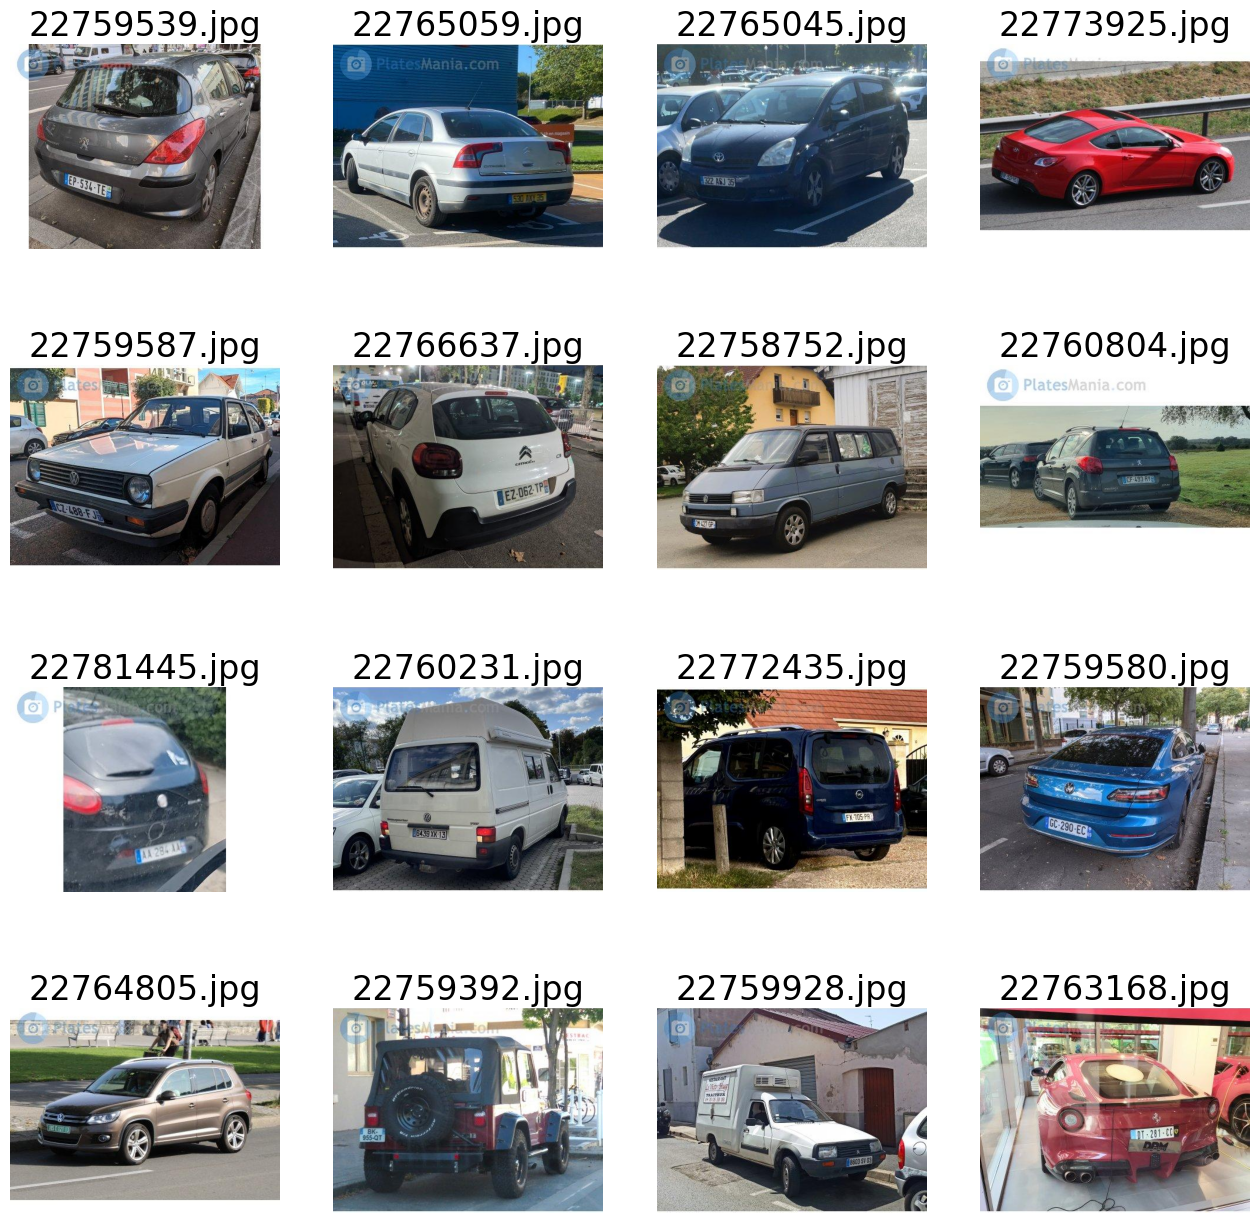

In [5]:
titles = [ os.path.basename(image_path) for image_path in image_paths[:SAMPLE_SIZE] ]

images = [ cv2.imread(str(image_path)) for image_path in image_paths[:SAMPLE_SIZE] ]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE )

## Setp 3- Labeling preperation :  Autolabel dataset with `GroundeSAM Model`

The Grounded-SAM Model is a combination of Grounding DINO and Segment Anything models.  This hybrid model is designed to detect and segment objects with text inputs to automate the labeling process for car images. <a href="https://github.com/IDEA-Research/Grounded-Segment-Anything"> GroundedSAM </a>

 <center> <img src="https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_new_demo_image.png" alt="DINO" width="1000"> </center> <br>
 <center> <img src="https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/ram_grounded_sam_new.png" alt="SAM" width="1000">

 


### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [6]:
# define two class label in text inputs
ontology=CaptionOntology({
    "car": "car",  
    "license plate": "license plate"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often `multimodal` and can perform many tasks. They're large, slow, and expensive. <br>
                 Examples of Base Models are `GroundedSAM and GPT-4'` upcoming multimodal variant. We use a Base Model (along with `unlabeled input data` and an Ontology) to create a Dataset.

**NOTE :**  Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕ **please use GPU to run this model. With one GPU with ~1000 images it took 1 day**                 

In [7]:
os.makedirs(os.path.join(run_dir, "datasets"), exist_ok=True)        # datasets path directory to store autolabel images after training GroundedSAM Model
DATASET_DIR_PATH = f"{run_dir}/datasets"

In [8]:
DATASET_DIR_PATH 

'./run/Object-Dection1/datasets'

In [ ]:
base_model = GroundedSAM(ontology = ontology)


dataset    = base_model.label(input_folder  = IMAGE_DIR_PATH,
                              extension     = ".jpg",
                              output_folder = DATASET_DIR_PATH
                             )

trying to load grounding dino directly
downloading dino model weights


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Labeling /content/drive/MyDrive/images/22786853.jpg:   0%|          | 0/995 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Labeling /content/drive/MyDrive/images/22758130.jpg: 100%|████

Labeled dataset created - ready for distillation.


### Output Grounded SAM Model  after training 

In [9]:
subprocess.run(f"tree -d {DATASET_DIR_PATH}", shell=True)  

./run/Object-Dection1/datasets
├── annotations
├── images
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

8 directories


CompletedProcess(args='tree -d ./run/Object-Dection1/datasets', returncode=0)

### Have a look autolabel images 

**dataset** - a dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [10]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(run_dir, "datasets/train/labels")             

IMAGES_DIRECTORY_PATH      = os.path.join(run_dir, "datasets/train/images")             

DATA_YAML_PATH             = os.path.join(run_dir, "datasets/data.yaml")                

In [11]:
# Exports the `dataset` to YOLO format

dataset = sv.DetectionDataset.from_yolo(images_directory_path      = IMAGES_DIRECTORY_PATH,
                                        annotations_directory_path = ANNOTATIONS_DIRECTORY_PATH,
                                        data_yaml_path             = DATA_YAML_PATH
                                       )


In [12]:
print("class labels:", dataset.classes)

class labels: ['car', 'license plate']


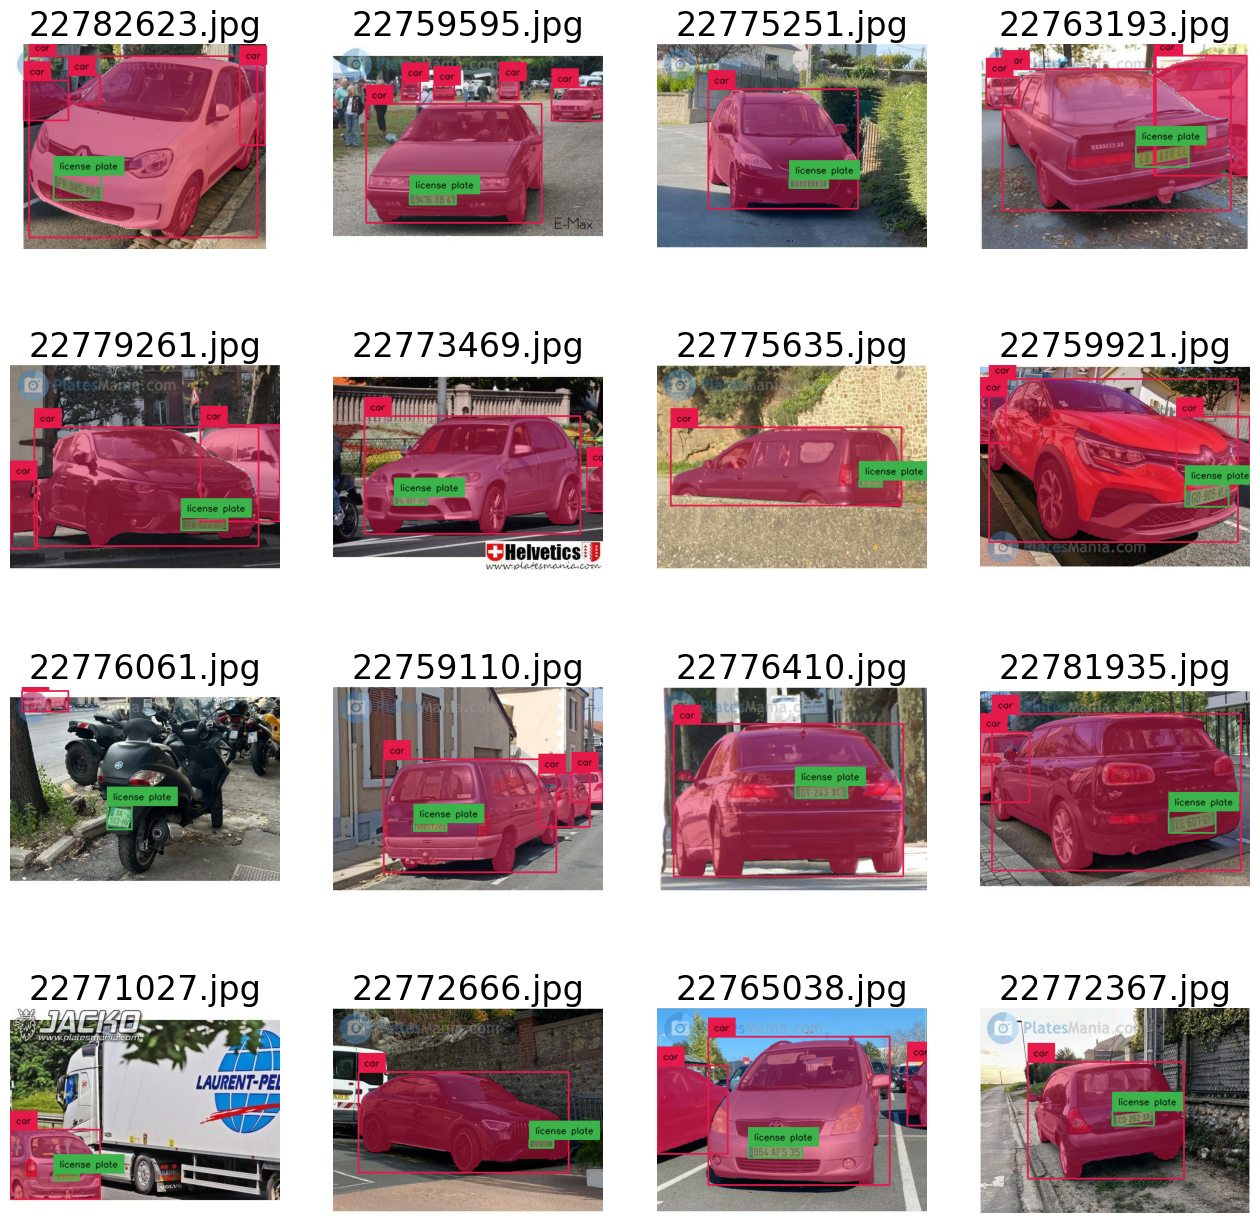

In [13]:
image_names    = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()                      # for drawing masks on an image
box_annotator  = sv.BoxAnnotator()                       # for drawing bounding boxes on an image

images         = []

for image_name in image_names:
    
    image           = dataset.images[image_name]
    annotations     = dataset.annotations[image_name]
    
    labels          = [ dataset.classes[class_id] for class_id  in annotations.class_id]

    annotates_image = mask_annotator.annotate(scene=image.copy(), detections=annotations)
    
    annotates_image = box_annotator.annotate(scene=annotates_image, detections=annotations, labels=labels)
    
    images.append(annotates_image)
    

sv.plot_images_grid(images=images, titles=image_names, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## Step 4 - Train model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [ ]:
model = YOLOv8("yolov8l.pt") # or YOLO('yolov8l.pt') : load an official model
model.train(DATA_YAML_PATH, epochs=100,imgsz=640)

100%|██████████| 83.7M/83.7M [00:01<00:00, 51.0MB/s]
New https://pypi.org/project/ultralytics/8.0.193 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/drive/MyDrive/datasets/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, vis

## Step 5 -  Evaluate target model

**NOTE :** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

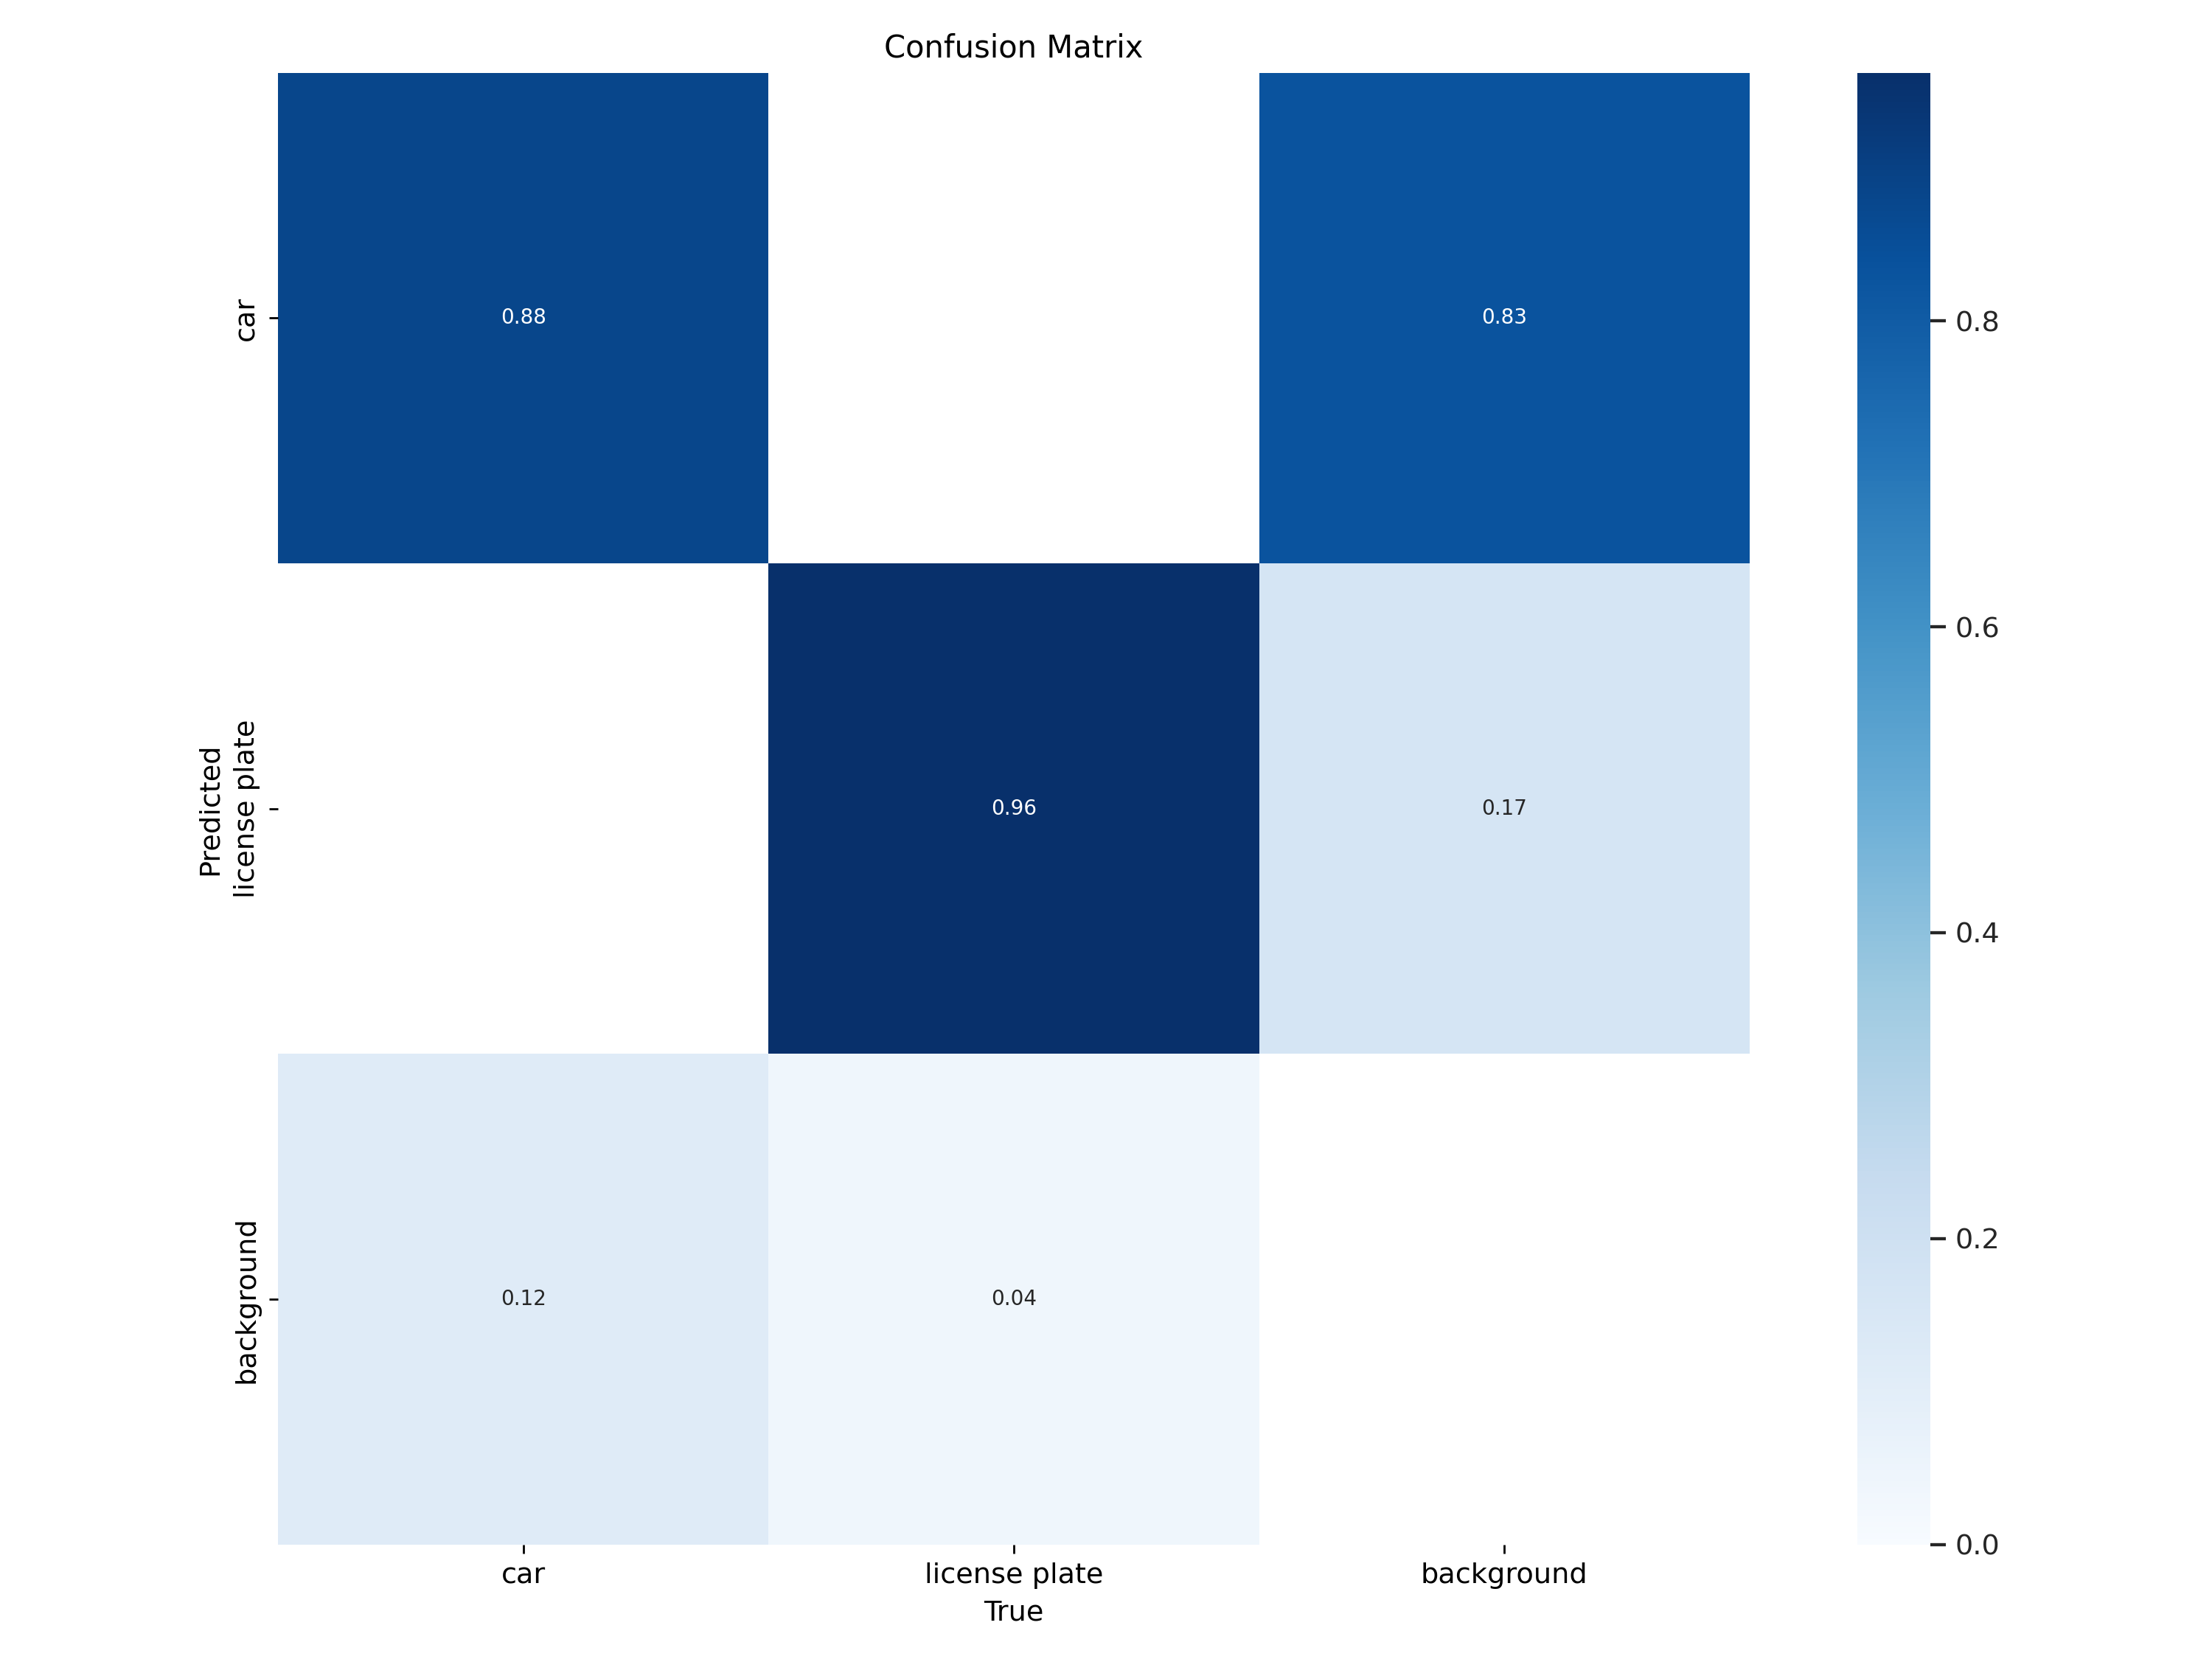

In [14]:
from IPython.display import Image

Image(filename='./runs/detect/train/confusion_matrix.png', width=1000)

In [15]:
from IPython.display import Image

Image(filename='./runs/detect/train/results.png', width=1000)

In [11]:
from IPython.display import Image

Image(filename='./runs/detect/train/val_batch0_pred.jpg', width=1000)

## Step 6 -  Run Inference on a video and  on a Image

In [47]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
os.makedirs("./inference_video", exist_ok=True)                                             
os.makedirs("./inference_image", exist_ok=True)                                                           
TRAINED_MODEL_PATH = "./runs/detect/train/weights/best.pt"               # path to best yolo model (custom trained model)

In [33]:
!yolo help


    Arguments received: ['yolo', 'help']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ('detect', 'segment', 'classify', 'pose')
                MODE (required) is one of ('train', 'val', 'predict', 'export', 'track', 'benchmark')
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco128.yaml model=yolov8n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolov8n-seg.pt source='https://youtu.be/Zgi9g1ksQHc' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolov8n.pt data=coco128.yaml batch=1 imgs

In [34]:
Image(filename='./inference_image/01.jpg', width=1000)

In [8]:
!yolo predict model={TRAINED_MODEL_PATH} source={"./inference_image/01.jpg"}

Ultralytics YOLOv8.0.81 🚀 Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (NVIDIA T600 Laptop GPU, 3906MiB)
Model summary (fused): 268 layers, 43608150 parameters, 0 gradients, 164.8 GFLOPs

image 1/1 /home/achille-touye/Downloads/Object_Detection/inference_image/01.jpg: 384x640 1 car, 1 license plate, 56.0ms
Speed: 0.5ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [13]:
Image(filename='./runs/detect/predict/01.jpg', width=1000)

In [52]:
from IPython.display import HTML

# Replace 'video.mp4' with your video file name 
INPUT_VIDEO_PATH   = "./inference_video/video.mp4"  

# Use HTML5 video tag to embed the video
video_html = """
<video width="640" height="360" controls>
  <source src="{}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""".format(INPUT_VIDEO_PATH )

# Display the HTML content
HTML(video_html)


In [18]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

Ultralytics YOLOv8.0.81 🚀 Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (NVIDIA T600 Laptop GPU, 3906MiB)
Model summary (fused): 268 layers, 43608150 parameters, 0 gradients, 164.8 GFLOPs

video 1/1 (1/1780) /home/achille-touye/Downloads/Object_Detection/inference_video/video.mp4: 640x384 4 cars, 1 license plate, 74.5ms
video 1/1 (2/1780) /home/achille-touye/Downloads/Object_Detection/inference_video/video.mp4: 640x384 2 cars, 1 license plate, 50.8ms
video 1/1 (3/1780) /home/achille-touye/Downloads/Object_Detection/inference_video/video.mp4: 640x384 5 cars, 1 license plate, 54.4ms
video 1/1 (4/1780) /home/achille-touye/Downloads/Object_Detection/inference_video/video.mp4: 640x384 3 cars, 1 license plate, 54.2ms
video 1/1 (5/1780) /home/achille-touye/Downloads/Object_Detection/inference_video/video.mp4: 640x384 2 cars, 1 license plate, 54.3ms
video 1/1 (6/1780) /home/achille-touye/Downloads/Object_Detection/inference_video/video.mp4: 640x384 2 cars, 1 license plate, 54.2ms
video 1/1 (7/1780) /

In [54]:
from IPython.display import HTML

Result_VIDEO_PATH = "./runs/detect/predict2/video.mp4"  

# Use HTML5 video tag to embed the video
video_html = """
<video width="640" height="360" controls>
  <source src="{}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""".format(Result_VIDEO_PATH)

# Display the HTML content
HTML(video_html)

In [23]:
fidle.end()

**End time :** 04/01/24 11:37:50  
**Duration :** 00:34:12 546ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

In [24]:
os.getcwd()

'/home/achille-touye/Downloads/Object_Detection'

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>